# Premier essai 'naif' de modèle

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize


In [2]:
train_data = pd.read_csv('ExoTrain.csv')
test_data = pd.read_csv('ExoTest.csv')

X_train, X_test, y_train, y_test = train_data.drop(['LABEL'], axis = 1), test_data.drop(['LABEL'], axis = 1), train_data['LABEL'],test_data['LABEL']
y_train = y_train-1
y_test = y_test-1

rfc = RandomForestClassifier(n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")



Accuracy: 0.9912280701754386


A première vue, il semble que le modèle soit très performant. Cependant, lorsque l'on regarde d'autres metrics, on observe ceci:

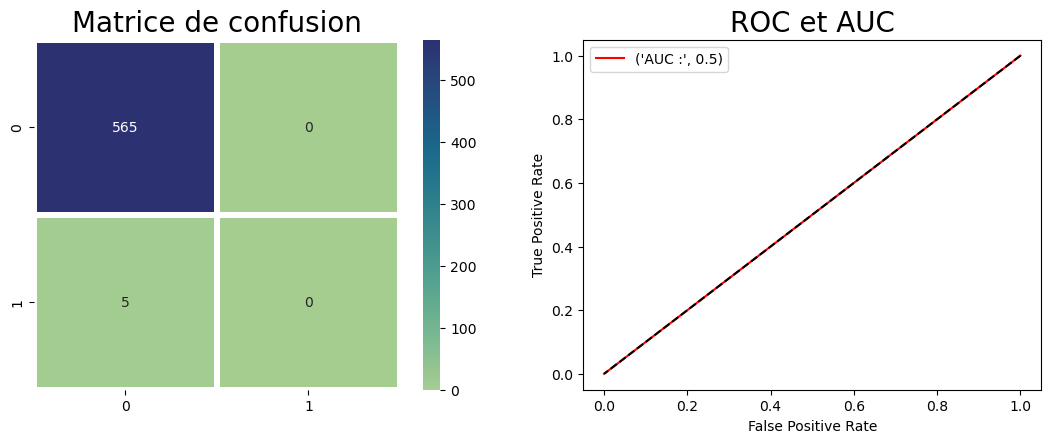

In [3]:
#Matrice de confusion
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="crest",fmt = "d",linewidths=3)
plt.title("Matrice de confusion",fontsize=20)

#ROC et AUC
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("AUC :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC et AUC",fontsize=20);

On remarque en effet que notre classifier est très proche de l'aléatoire pur, ce que l'on ne pouvait pas remarquer avec seulement l'accuracy. Cela est du au nombre très faible d'une des deux classes par rapport à l'autre. Pour corriger ce problème, nous allons utiliser une méthode de weight balancing

Accuracy: 0.643859649122807


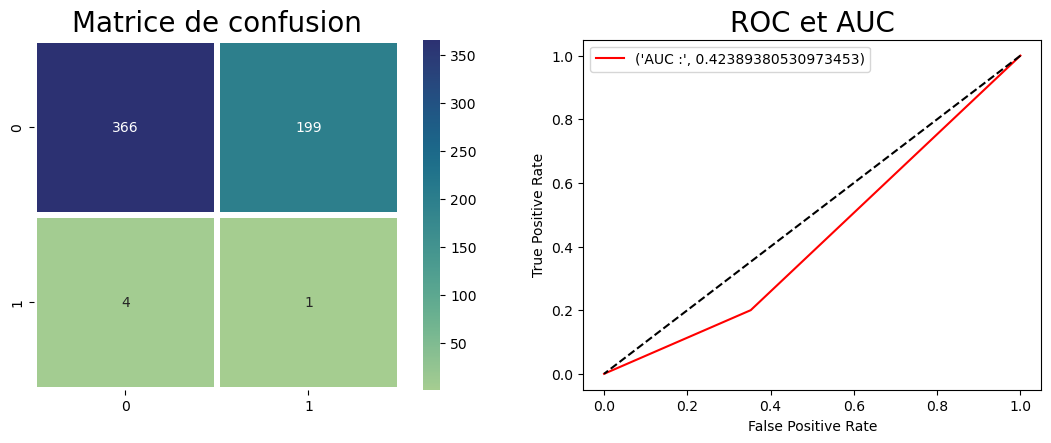

In [4]:

#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(y_train),y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

lr = LogisticRegression(class_weight=class_weights, max_iter=1000)
lr.fit(X_train, y_train)


y_pred = lr.predict(X_test)

#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


#Matrice de confusion
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="crest",fmt = "d",linewidths=3)
plt.title("Matrice de confusion",fontsize=20)

#ROC et AUC
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("AUC :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC et AUC",fontsize=20);

On voit maintenant que l'accuracy diminue drastiquement, puisque le modèle ne se contente plus de prédire toujours la même classe. Nous allons donc devoir améliorer notre modèle

In [5]:
class_weights

{0: 0.5036633663366337, 1: 68.74324324324324}

# Traitement des données

## Valeurs manquantes 

In [6]:
train_data.isna().sum().sum()

0

Aucune valeur manquante dans le dataframe, aucun travail ne sera nécéssaire de ce côté

## Visualisation de la data

Nous allons visualiser différents plots de l'évolution du flux pour observer les éventuelles particularités d'un type d'étoile ou l'autre. En vert si c'est une étoile pouvant avoir une exoplanète en orbite, en bleu sinon

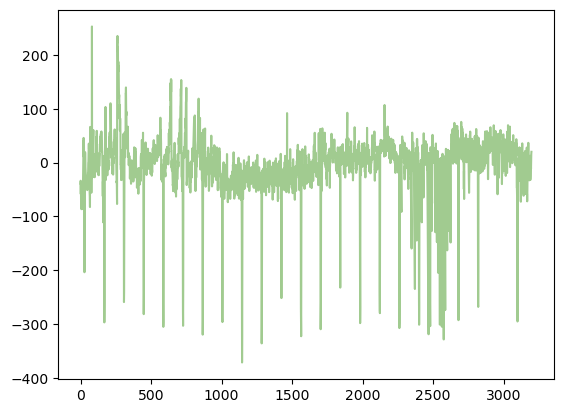

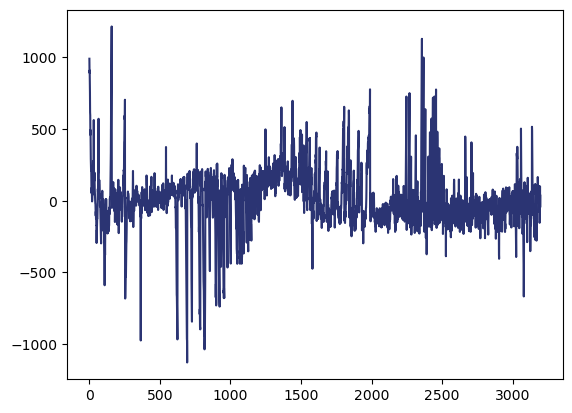

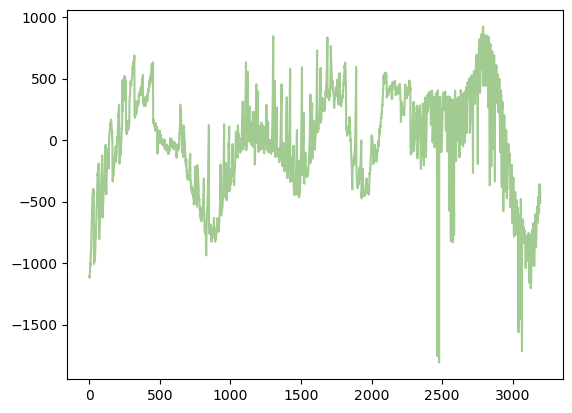

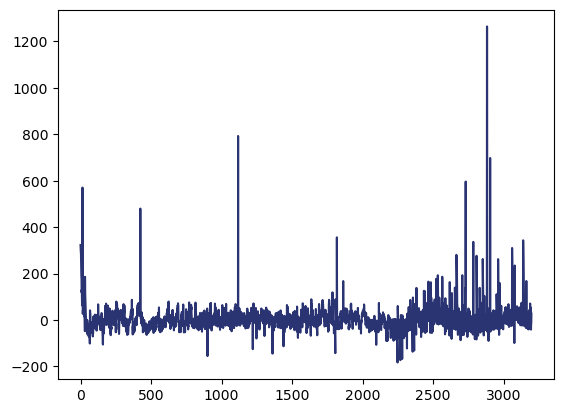

In [7]:
for i in [1,5083,4,5086]:
    l = []
    for j in X_train.columns:
        l = l + [X_train[j][i]]
        
    if(y_train[i]==1): #plot en vert si c'est une étoile pouvant avoir une exoplanète en orbite
        plt.plot(l, color = '#a1cb90')
        
    else:
        plt.plot(l, color = '#2b3473')
    plt.show()

Observer ces données nous permet d'observer que celle-ci est perturbée par du bruit qu'il serait judicieux de traiter. Nous allon essayer de trouver une méthode pour supprimer le bruit mais sans retirer ce qui fait la différence entre les deux classes et permet de prédire.

## Corrélations

Observons les corrélations 

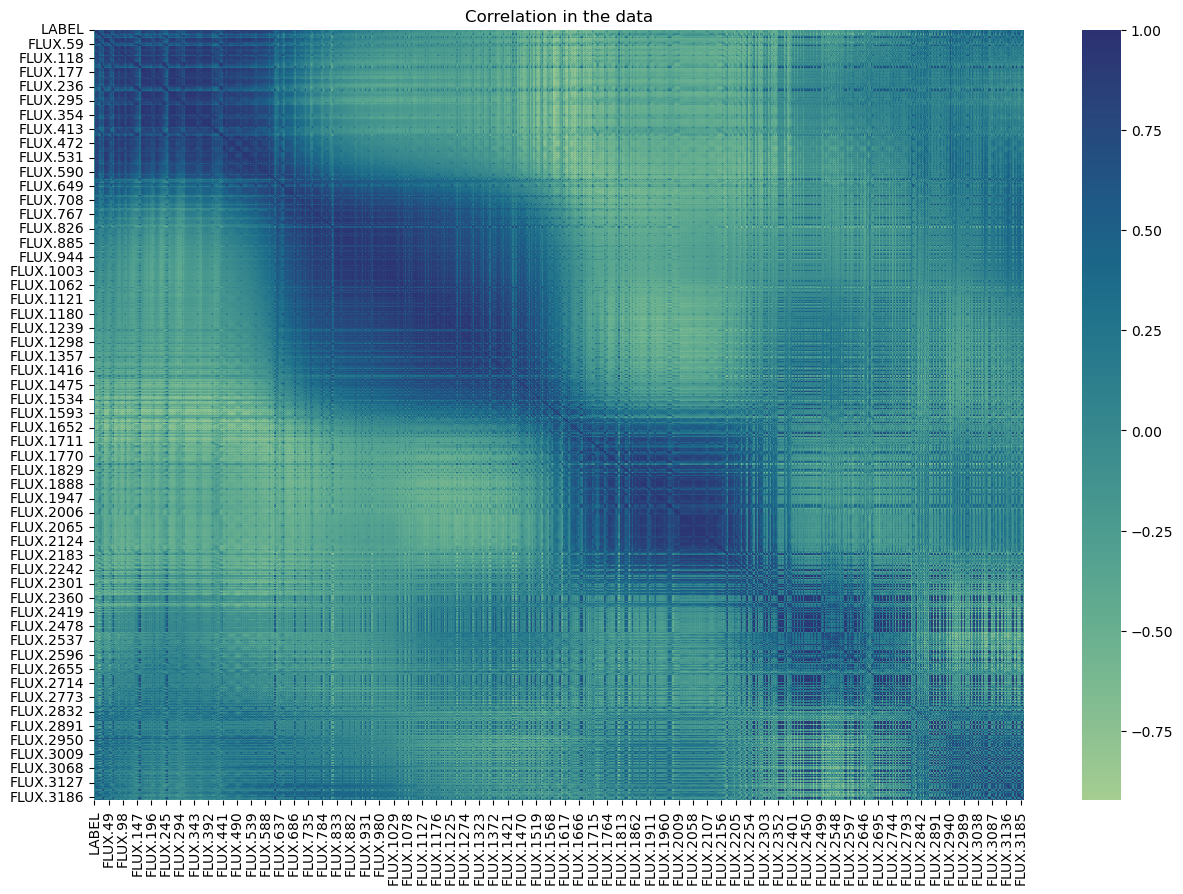

In [8]:
plt.figure(figsize=(15,10))
sns.heatmap(train_data.corr(),cmap="crest")
plt.title('Correlation in the data')
plt.show()

Les corrélations sont assez logiques : le flux pris à $t_{i}$ est fortement corrélé a celui relevé à $t_{i-1}$, d'où les "tâches" que l'on observe sur le plot.

## Smoothing

Nous avons ici tenté plusieurs techniques de smoothing : exponentiel et gaussien. Nous avons ainsi 3 dataframes différents (avec le dataframe "brut") permettant de comparer et voir si cela a un réel impact.

### Smoothing exponentiel

In [9]:
X_train.iloc[i]

FLUX.1       323.28
FLUX.2       306.36
FLUX.3       293.16
FLUX.4       287.67
FLUX.5       249.89
              ...  
FLUX.3193    -25.33
FLUX.3194    -41.31
FLUX.3195    -16.72
FLUX.3196    -14.09
FLUX.3197     27.82
Name: 5086, Length: 3197, dtype: float64

In [10]:
def exponential_smoothing(series, alpha):
    
    smoothed_series = series.copy()

    smoothed_series.iloc[0] = series.iloc[0]

    # On applique le smoothing sur la copie
    for i in range(1, len(series)):
        smoothed_series.iloc[i] = alpha * series.iloc[i] + (1 - alpha) * smoothed_series.iloc[i - 1]

    return smoothed_series

In [11]:
# Facteur de smoothing
alpha = 0.3

# On copie dataframe car on modélisera sur les deux pour comparer
smoothed_df = pd.DataFrame(columns=X_train.columns)

for i in range(len(X_train)):
    smoothed_series = exponential_smoothing(X_train.iloc[i], alpha)
    smoothed_df = smoothed_df.append(smoothed_series, ignore_index=True)


smoothed_df.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,90.838,69.6166,40.63762,16.578334,-25.808166,-58.619716,-69.914801,-72.907361,-99.086153,...,-20.382182,-44.912527,-62.083769,-35.919638,-10.572747,20.361077,26.048754,36.660128,27.186089,7.168263
1,-38.88,-37.365,-43.7175,-42.62925,-53.633475,-59.386432,-67.535503,-72.873852,-76.202696,-75.355887,...,-1.578320,-10.767824,-17.200477,-19.507334,-15.113134,-10.351194,-10.755836,-5.591085,0.886241,6.599368
2,532.64,533.624,527.6558,518.43506,499.839542,489.687679,482.131376,483.408963,469.354274,473.864992,...,-59.225574,-37.464902,-22.232431,-24.529702,-23.434791,-14.886354,-13.960448,-18.445313,-33.917719,-52.743404
3,326.52,332.781,323.6517,315.99519,316.518633,315.373043,317.460130,315.615091,314.656564,317.258595,...,-6.663145,-5.783201,-5.167241,5.397931,9.787552,3.050286,-0.495800,-5.540060,-9.083042,-2.164129
4,-1107.21,-1108.824,-1111.8618,-1106.83326,-1092.048282,-1074.777797,-1051.846458,-1043.105521,-1027.044865,-1010.195405,...,-539.252377,-497.974664,-469.080265,-435.528185,-437.997730,-438.160411,-426.625288,-414.032701,-413.359891,-442.513924


On print anciennes et nouvelles courbes pour observer l'effet du smoothing

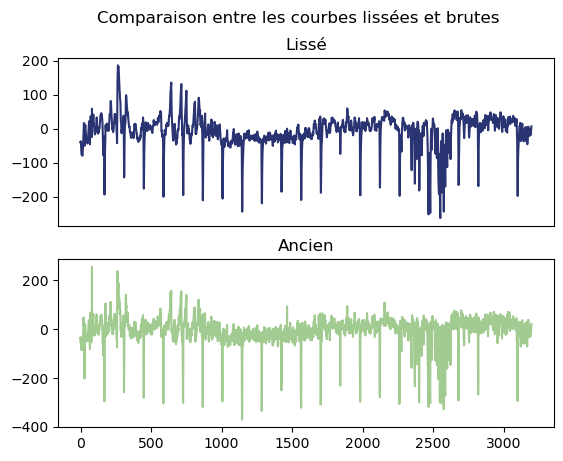

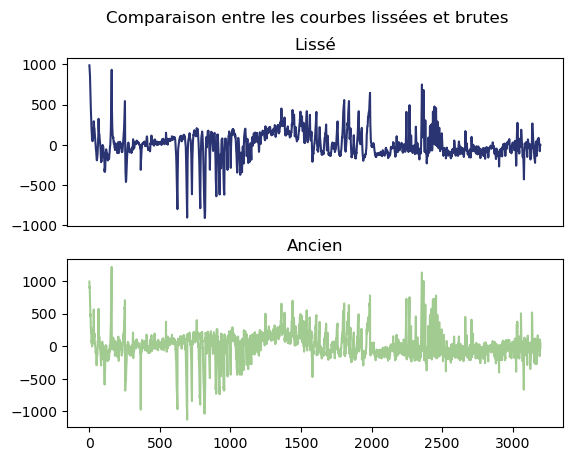

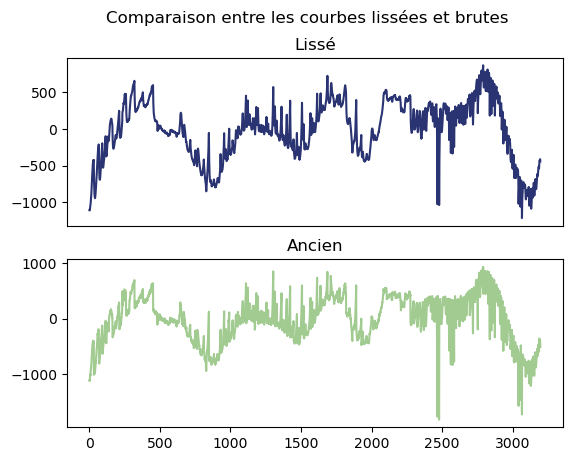

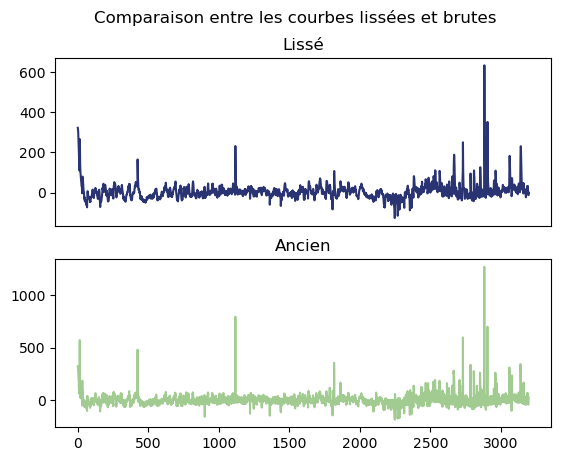

In [12]:
for i in [1,5083,4,5086]:
    l = []
    l2 = []
    for j in X_train.columns:
        l = l + [smoothed_df[j][i]]
        l2 = l2 + [X_train[j][i]]

   
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Comparaison entre les courbes lissées et brutes')
    ax1.plot(l, color = '#2b3473') 
    ax2.plot(l2, color = '#a1cb90')
    ax1.set_title('Lissé')
    ax1.axes.get_xaxis().set_visible(False)
    ax2.set_title('Ancien')

#### Smoothing Gaussien

In [13]:
from scipy import signal

def gaussian_smoothing(series, window_size, sigma):

    gauss_window = signal.windows.gaussian(window_size, std=sigma)

    gauss_window /= np.sum(gauss_window)

    smoothed_data = np.convolve(series, gauss_window, mode='same')

    return pd.Series(smoothed_data, index=series.index)

In [14]:
window = 30
sigma = 5

gaussian_Xtrain = pd.DataFrame(columns=X_train.columns)
gaussian_Xtest = pd.DataFrame(columns=X_test.columns)

for i in range(len(X_train)):
    smoothed_series = gaussian_smoothing(X_train.iloc[i], window, sigma)
    gaussian_Xtrain = gaussian_Xtrain.append(smoothed_series, ignore_index=True)

for i in range(len(X_test)):
    smoothed_series = gaussian_smoothing(X_test.iloc[i], window, sigma)
    gaussian_Xtest = gaussian_Xtest.append(smoothed_series, ignore_index=True)


gaussian_Xtrain.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,-8.479069,-15.638528,-24.611345,-35.134541,-46.889097,-59.213495,-71.536563,-83.202197,-93.500546,-101.951946,...,-4.632413,-4.162349,-3.182376,-1.632731,0.225831,2.412566,4.332867,5.723949,6.513567,6.728258
1,-29.195373,-34.975877,-40.882554,-46.721256,-52.238637,-57.202566,-61.428794,-64.732801,-66.966252,-68.093301,...,-8.809984,-8.438690,-7.907018,-7.213459,-6.288557,-5.203584,-4.023614,-2.822539,-1.690125,-0.695650
2,248.685416,286.549177,322.449368,355.110113,383.658069,407.652092,427.189316,442.648839,454.745667,464.296812,...,-31.035775,-30.478182,-29.627889,-28.619828,-27.576501,-26.506890,-25.383013,-24.132440,-22.719122,-21.089229
3,159.231595,184.302224,208.361512,230.586541,250.359468,267.329737,281.395287,292.740549,301.690745,308.697026,...,-5.118458,-4.066617,-3.149872,-2.410947,-1.866728,-1.503129,-1.294220,-1.205059,-1.179472,-1.157304
4,-533.877656,-614.533838,-689.923201,-756.816063,-812.792171,-856.383829,-887.074532,-905.236490,-911.888497,-908.468037,...,-470.068627,-454.830840,-437.984202,-419.114402,-397.834109,-373.677740,-346.637897,-316.851539,-284.626526,-250.693102


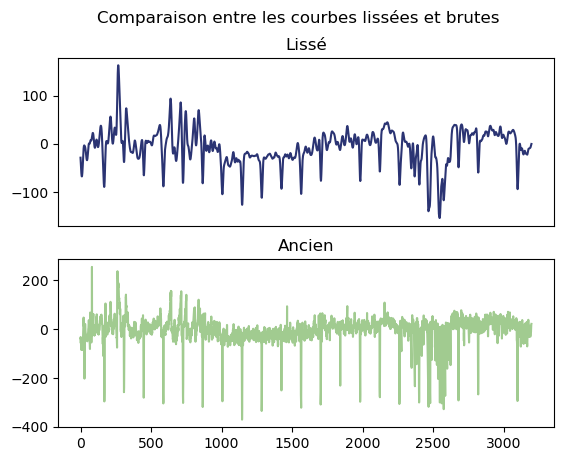

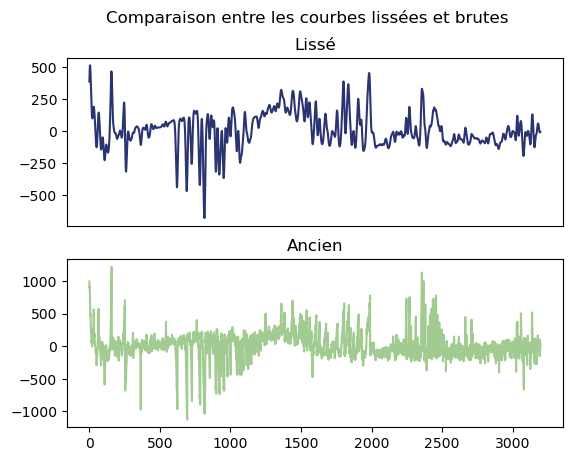

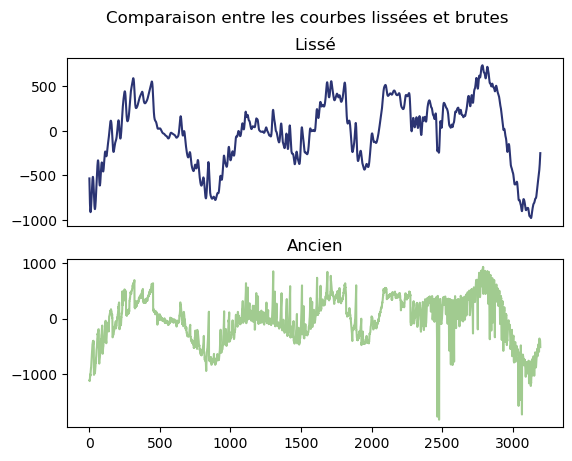

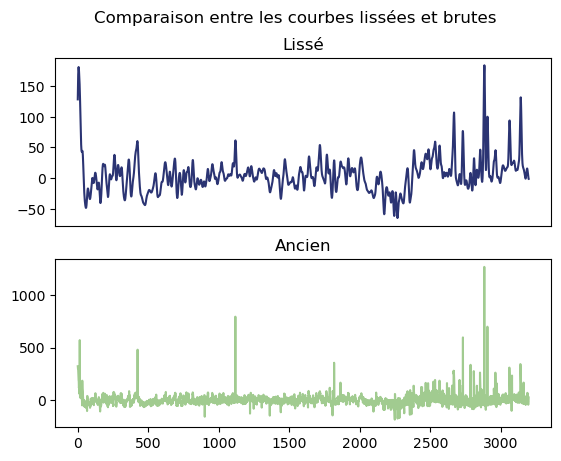

In [15]:
for i in [1,5083,4,5086]:
    l = []
    l2 = []
    for j in X_train.columns:
        l = l + [gaussian_Xtrain[j][i]]
        l2 = l2 + [X_train[j][i]]


    
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Comparaison entre les courbes lissées et brutes')
    ax1.plot(l, color = '#2b3473') 
    ax2.plot(l2, color = '#a1cb90')
    ax1.set_title('Lissé')
    ax1.axes.get_xaxis().set_visible(False)
    ax2.set_title('Ancien')

## Outliers

Premièrement, il est important de savoir si les outliers doivent être traités ou non, c'est à dire si ils sont une caractéristique de l'un des deux types d'étoile. Pour cela, nous visualisons les outliers à l'aide d'un boxplot 

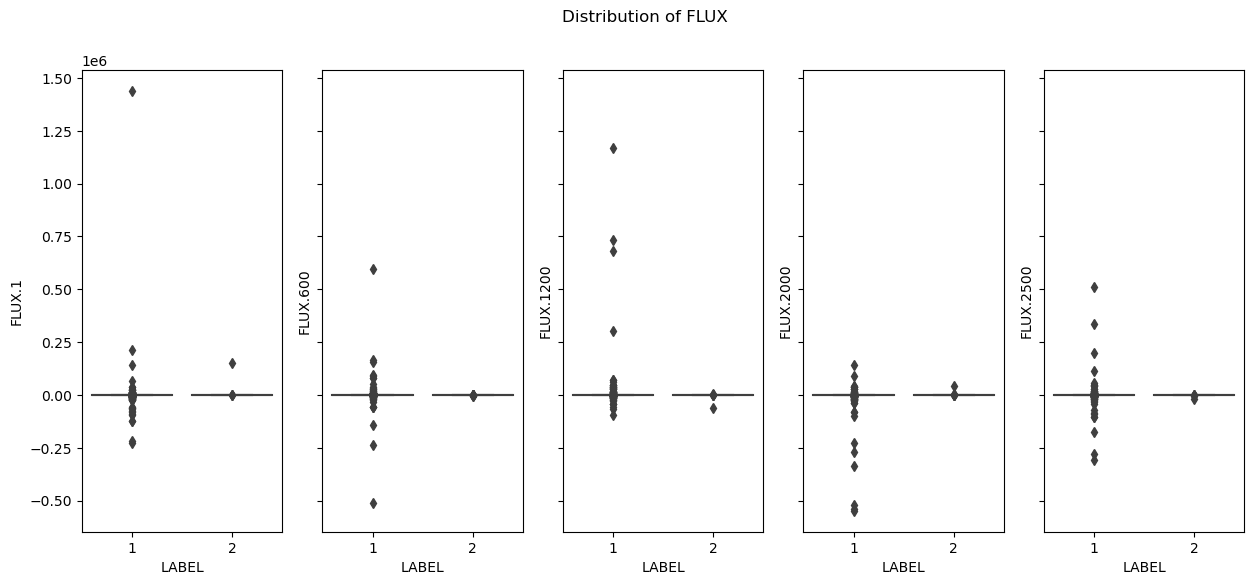

In [16]:
fig, axes = plt.subplots(1, 5,figsize=(15, 6), sharey=True)
fig.suptitle('Distribution of FLUX')

sns.boxplot(ax=axes[0], data=train_data, x='LABEL', y='FLUX.1')
sns.boxplot(ax=axes[1], data=train_data, x='LABEL', y='FLUX.600')
sns.boxplot(ax=axes[2], data=train_data, x='LABEL', y='FLUX.1200')
sns.boxplot(ax=axes[3], data=train_data, x='LABEL', y='FLUX.2000')
sns.boxplot(ax=axes[4], data=train_data, x='LABEL', y='FLUX.2500');


Les valeurs extrêmes ne semblent pas être une caractéristique car il y en a assez peu en comparaison au nombre de données (aucune pour les étoiles à exoplanètes mais cela est sûrement dû au nombre très faible)

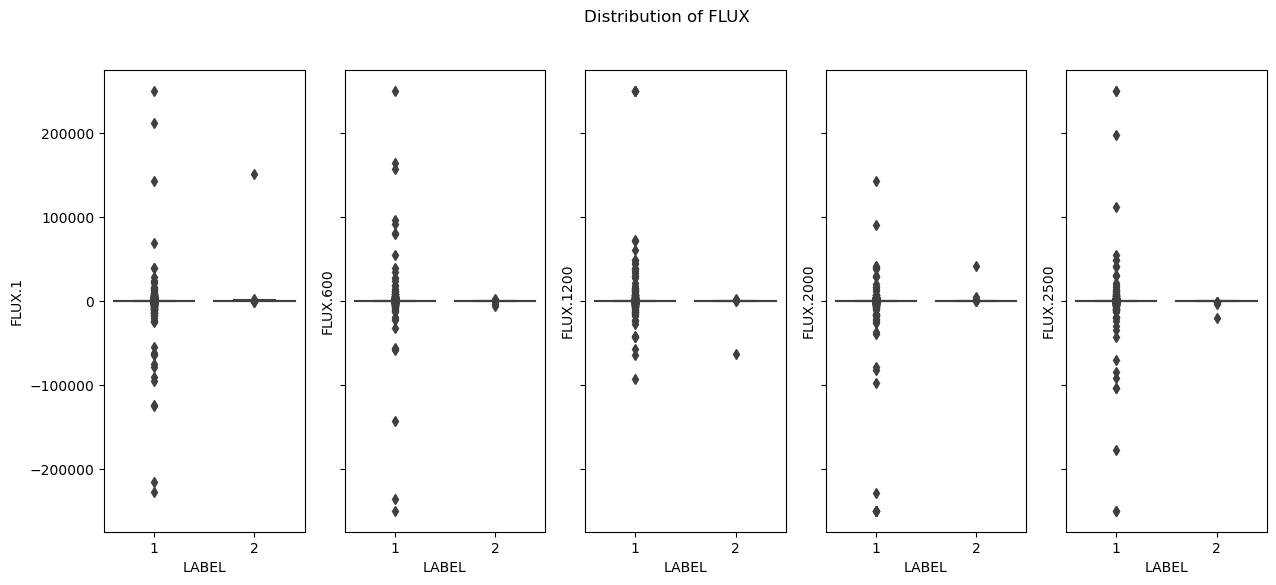

In [17]:
for i in X_train.columns:
    # définition des bornes
    lower_bound = -250000
    upper_bound = 250000

    # on remplace les outliers par la borne
    train_data.loc[train_data[i] < lower_bound, i] = lower_bound
    train_data.loc[train_data[i] > upper_bound, i] = upper_bound


fig, axes = plt.subplots(1, 5,figsize=(15, 6), sharey=True)
fig.suptitle('Distribution of FLUX')
sns.boxplot(ax=axes[0], data=train_data, x='LABEL', y='FLUX.1')
sns.boxplot(ax=axes[1], data=train_data, x='LABEL', y='FLUX.600')
sns.boxplot(ax=axes[2], data=train_data, x='LABEL', y='FLUX.1200')
sns.boxplot(ax=axes[3], data=train_data, x='LABEL', y='FLUX.2000')
sns.boxplot(ax=axes[4], data=train_data, x='LABEL', y='FLUX.2500');

## Normalisation

In [18]:
X_train_processed = normalized = normalize(gaussian_Xtrain)
X_test_processed = normalize(gaussian_Xtest)

X_train_processed = pd.DataFrame(X_train_processed, columns=X_train.columns)
X_test_processed = pd.DataFrame(X_test_processed, columns=X_train.columns)

X_train_processed.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,-0.001243,-0.002293,-0.003609,-0.005153,-0.006876,-0.008684,-0.010491,-0.012202,-0.013712,-0.014951,...,-0.000679,-0.000610,-0.000467,-0.000239,0.000033,0.000354,0.000635,0.000839,0.000955,0.000987
1,-0.013726,-0.016444,-0.019221,-0.021966,-0.024559,-0.026893,-0.028880,-0.030433,-0.031484,-0.032013,...,-0.004142,-0.003967,-0.003717,-0.003391,-0.002957,-0.002446,-0.001892,-0.001327,-0.000795,-0.000327
2,0.017418,0.020069,0.022584,0.024871,0.026871,0.028551,0.029920,0.031002,0.031850,0.032519,...,-0.002174,-0.002135,-0.002075,-0.002004,-0.001931,-0.001857,-0.001778,-0.001690,-0.001591,-0.001477
3,0.028169,0.032604,0.036861,0.040792,0.044290,0.047292,0.049781,0.051788,0.053371,0.054611,...,-0.000905,-0.000719,-0.000557,-0.000427,-0.000330,-0.000266,-0.000229,-0.000213,-0.000209,-0.000205
4,-0.025128,-0.028924,-0.032473,-0.035621,-0.038256,-0.040308,-0.041752,-0.042607,-0.042920,-0.042759,...,-0.022125,-0.021408,-0.020615,-0.019727,-0.018725,-0.017588,-0.016315,-0.014913,-0.013397,-0.011799


# Modélisation

Accuracy: 0.8929824561403509


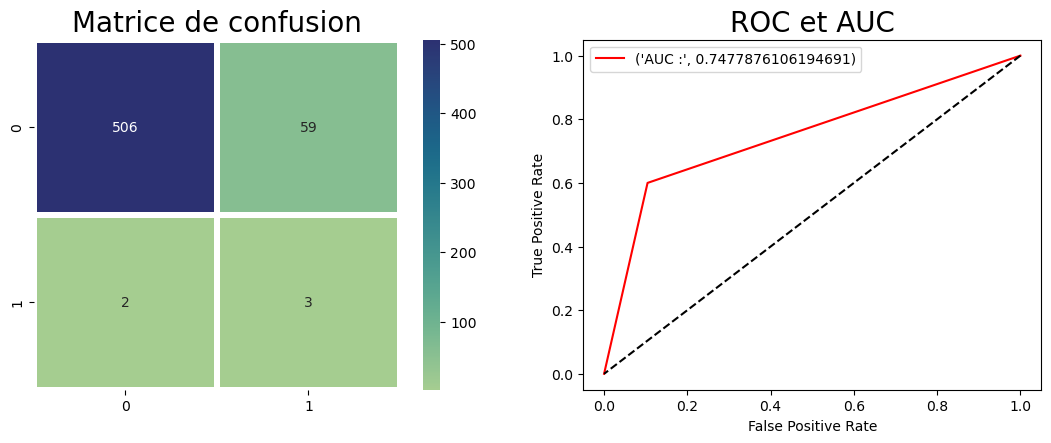

In [19]:
lr = LogisticRegression(class_weight=class_weights, max_iter=1000)
lr.fit(X_train_processed, y_train)


y_pred = lr.predict(X_test_processed)

#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


#Matrice de confusion
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="crest",fmt = "d",linewidths=3)
plt.title("Matrice de confusion",fontsize=20)

#ROC et AUC
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("AUC :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC et AUC",fontsize=20);

## KNN

In [20]:
# Le class balancing est un petit peu différent pour le KNN
from imblearn.over_sampling import SMOTE
model = SMOTE()
ov_train_x,ov_train_y = model.fit_resample(X_train_processed, y_train)
ov_train_y = ov_train_y.astype('int')

Accuracy 0.9245614035087719


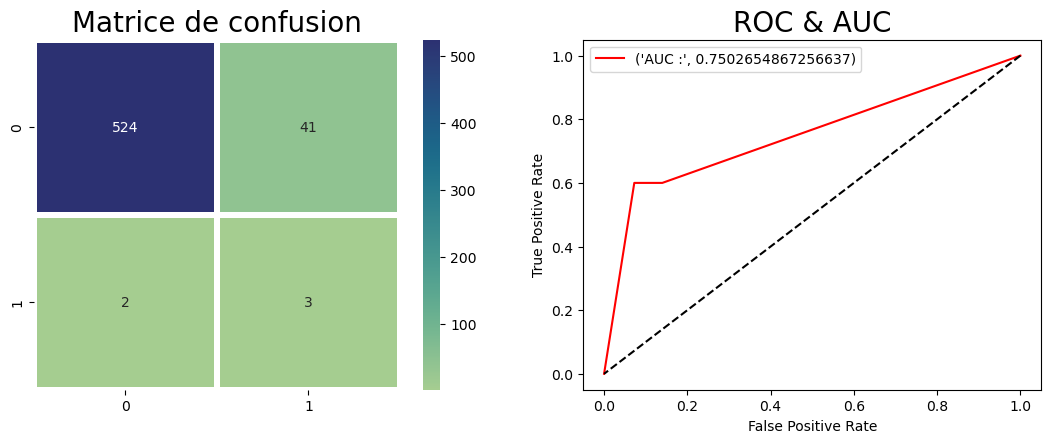

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(weights='distance',n_neighbors=2)

knn_model.fit(ov_train_x,ov_train_y)

y_pred=knn_model.predict(X_test_processed)

print('Accuracy', accuracy_score(y_pred,y_test))

#Matrice de confusion
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="crest",fmt = "d",linewidths=3)
plt.title("Matrice de confusion",fontsize=20)

#ROC & AUC
predicting_probabilites = knn_model.predict_proba(X_test_processed)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,predicting_probabilites)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("AUC :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC & AUC",fontsize=20);

## Decision Tree

Accuracy: 0.8421052631578947


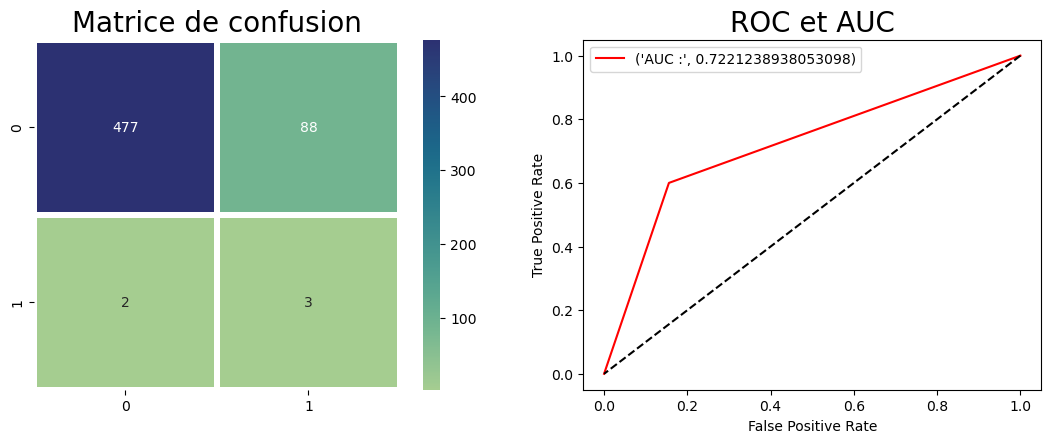

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
ds_model = DecisionTreeClassifier(max_depth=6, random_state=42)

ds_model.fit(ov_train_x,ov_train_y)

y_pred=ds_model.predict(X_test_processed)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


#Matrice de confusion
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap="crest",fmt = "d",linewidths=3)
plt.title("Matrice de confusion",fontsize=20)

#ROC et AUC
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
plt.subplot(222)
plt.plot(fpr,tpr,label = ("AUC :",auc(fpr,tpr)),color = "r")
plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
plt.legend(loc = "best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC et AUC",fontsize=20);

## Deep learning

In [65]:
#reset des dataframes par précaution
X_train, X_test, y_train, y_test = train_data.drop(['LABEL'], axis = 1), test_data.drop(['LABEL'], axis = 1), train_data['LABEL'],test_data['LABEL']
X_train, X_test, y_train, y_test = X_train.astype(np.float32), X_test.astype(np.float32), y_train.astype(np.float32), y_test.astype(np.float32)
y_train = y_train-1
y_test = y_test -1

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.utils import class_weight
from tensorflow.keras import backend as K

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [66]:

#Scale 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Reshape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#weights
class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(y_train),y = y_train)
print('Class weights:', class_weights)

# fonction de cross-entropy pondérée (loss custom)
def weighted_bce(y_true, y_pred):
    weights = K.constant(class_weights)
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = K.mean(weights * bce)
    return weighted_bce

# LSTM
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss=weighted_bce, metrics=['accuracy'])

# Train
model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2, verbose=2)


Class weights: [ 0.50366337 68.74324324]
Epoch 1/3
128/128 - 127s - loss: nan - accuracy: 0.9909 - val_loss: nan - val_accuracy: 1.0000 - 127s/epoch - 992ms/step
Epoch 2/3
128/128 - 125s - loss: nan - accuracy: 0.9909 - val_loss: nan - val_accuracy: 1.0000 - 125s/epoch - 975ms/step
Epoch 3/3
128/128 - 124s - loss: nan - accuracy: 0.9909 - val_loss: nan - val_accuracy: 1.0000 - 124s/epoch - 967ms/step


Test accuracy: 0.9912280440330505
18/18 [==============================] - 4s 246ms/step


Text(0.5, 1.0, 'Matrice de confusion')

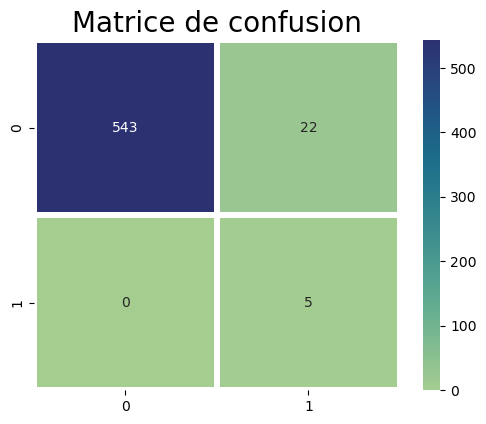

In [79]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', accuracy)

y_pred = model.predict(X_test)

threshold = 0.5
binary_predictions = (y_pred >= threshold).astype(int)

#Matrice de confusion
plt.figure(figsize=(13,10))
plt.subplot(221)
sns.heatmap(confusion_matrix(y_test,binary_predictions),annot=True,cmap="crest",fmt = "d",linewidths=3)

plt.title("Matrice de confusion",fontsize=20)